In [126]:
import numpy as np
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import skimage
import cv2

In [127]:
#original 512 x 512
i_width = 64
i_height = 64
input_shape = i_width*i_height

In [128]:
def AddImage(path):
  ds = dicom.dcmread(path)

  image = ds.pixel_array
  image = image.astype(np.int16)
  image[image == -2000] = 0
  
  # Convert to Hounsfield units (HU)
  intercept = ds.RescaleIntercept
  slope = ds.RescaleSlope
  
  if slope != 1:
      image = slope * image.astype(np.float64)
      image = image.astype(np.int16)
      
  image += np.int16(intercept)
  image =  np.array(image, dtype=np.float32)
  #resize for more faster nn learning
  image = skimage.transform.resize(image, (i_height, i_width))
  return image

def AddImageToArray(x,folderPath):
  patchs = os.listdir(folderPath)
  for filename in sorted(patchs, key=len):
    f = os.path.join(folderPath, filename)
    if os.path.isfile(f):
      x.append(AddImage(os.path.join(folderPath, filename)))
    else:
      AddImageToArray(x,f)

In [129]:
x_trn = []
x_tst = []

AddImageToArray(x_trn ,'DICOM\skulls\skull8')
AddImageToArray(x_tst ,'DICOM\PA5\ST1\SE4')

x_trn = np.array(x_trn, np.float32)
x_tst = np.array(x_tst, np.float32)

In [130]:
max_value = np.max(x_trn)
print(max_value)
x_trn /= max_value
x_tst /= max_value

showing_ratio = 0.05
x_trn = np.where(x_trn > showing_ratio, 1.0, 0.0)
x_tst = np.where(x_tst > showing_ratio, 1.0, 0.0)
x_trn = np.array(x_trn, np.float32)
x_tst = np.array(x_tst, np.float32)

print(len(x_trn ))
print(x_trn.shape)
print(x_trn[0].max())

1654.955
234
(234, 64, 64)
1.0


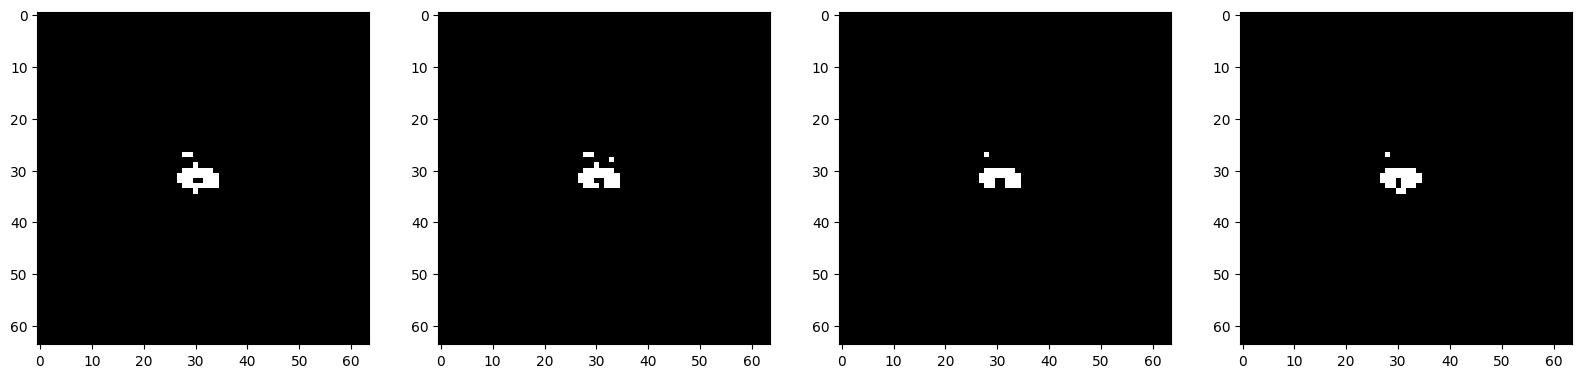

In [131]:
k = 4
plt.figure(figsize=(25,25))
for i in range(4):
  plt.subplot(5,5, i+1)
  plt.imshow(x_trn[k], cmap='gray')
  k+=1

plt.show()

In [132]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p
    
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [133]:
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

In [134]:
#use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = build_unet().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-5)

# mean-squared error loss
criterion = nn.MSELoss()

In [135]:
def train(epochs, model, criterion, optimizer, train_loader):
    for epoch in range(epochs):
        loss = 0
        for batch_features in train_loader:

            batch_features = batch_features.view(-1, 1, i_height, i_width).to(device) #.view(-1, 1, i_height, i_width)
            optimizer.zero_grad()
            
            # compute reconstructions
            outputs = model(batch_features)
            
            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)
            
            # compute accumulated gradients
            train_loss.backward()
            
            # perform parameter update based on current gradients
            optimizer.step()
            
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
        
        # compute the epoch training loss
        loss = loss / len(train_loader)
        
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    
    return model

In [136]:
train_loader = torch.utils.data.DataLoader(
    x_trn, batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    x_tst, batch_size=32, shuffle=False
)

In [143]:
model = train(1000, model, criterion, optimizer, train_loader)

epoch : 1/1000, loss = 0.049574
epoch : 2/1000, loss = 0.048051
epoch : 3/1000, loss = 0.046485
epoch : 4/1000, loss = 0.045337
epoch : 5/1000, loss = 0.044276
epoch : 6/1000, loss = 0.043336
epoch : 7/1000, loss = 0.042255


KeyboardInterrupt: 

In [144]:
test_examples = []
with torch.no_grad():
    for batch_features in test_loader:
        test_examples = np.array(batch_features)
        batch_features = batch_features.view(-1, 1, i_height, i_width).to(device)
        reconstruction = model(batch_features)
        break

2.8593068


<Figure size 2500x2500 with 0 Axes>

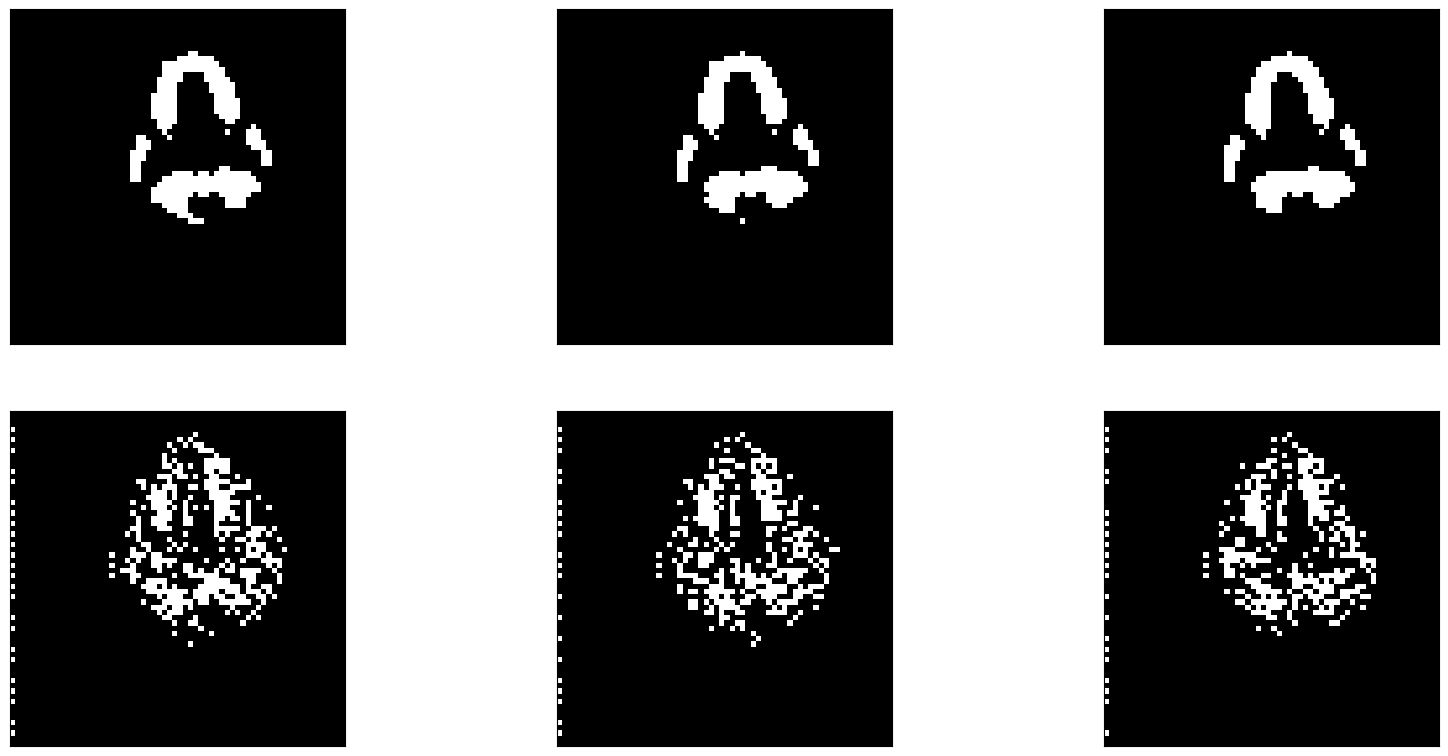

In [145]:
plt.figure(figsize=(25,25))
print(np.max(np.array(reconstruction)))
with torch.no_grad():
    number = 3
    plt.figure(figsize=(20, 20))
    for index in range(number):
        # display original
        ax = plt.subplot(4, number, index + 1)
        plt.imshow(test_examples[index].reshape(i_height, i_width))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(4, number, index + 1 + number)
        plt.imshow(np.where(reconstruction[index].numpy().reshape(i_height, i_width) > 0.3,1,0))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

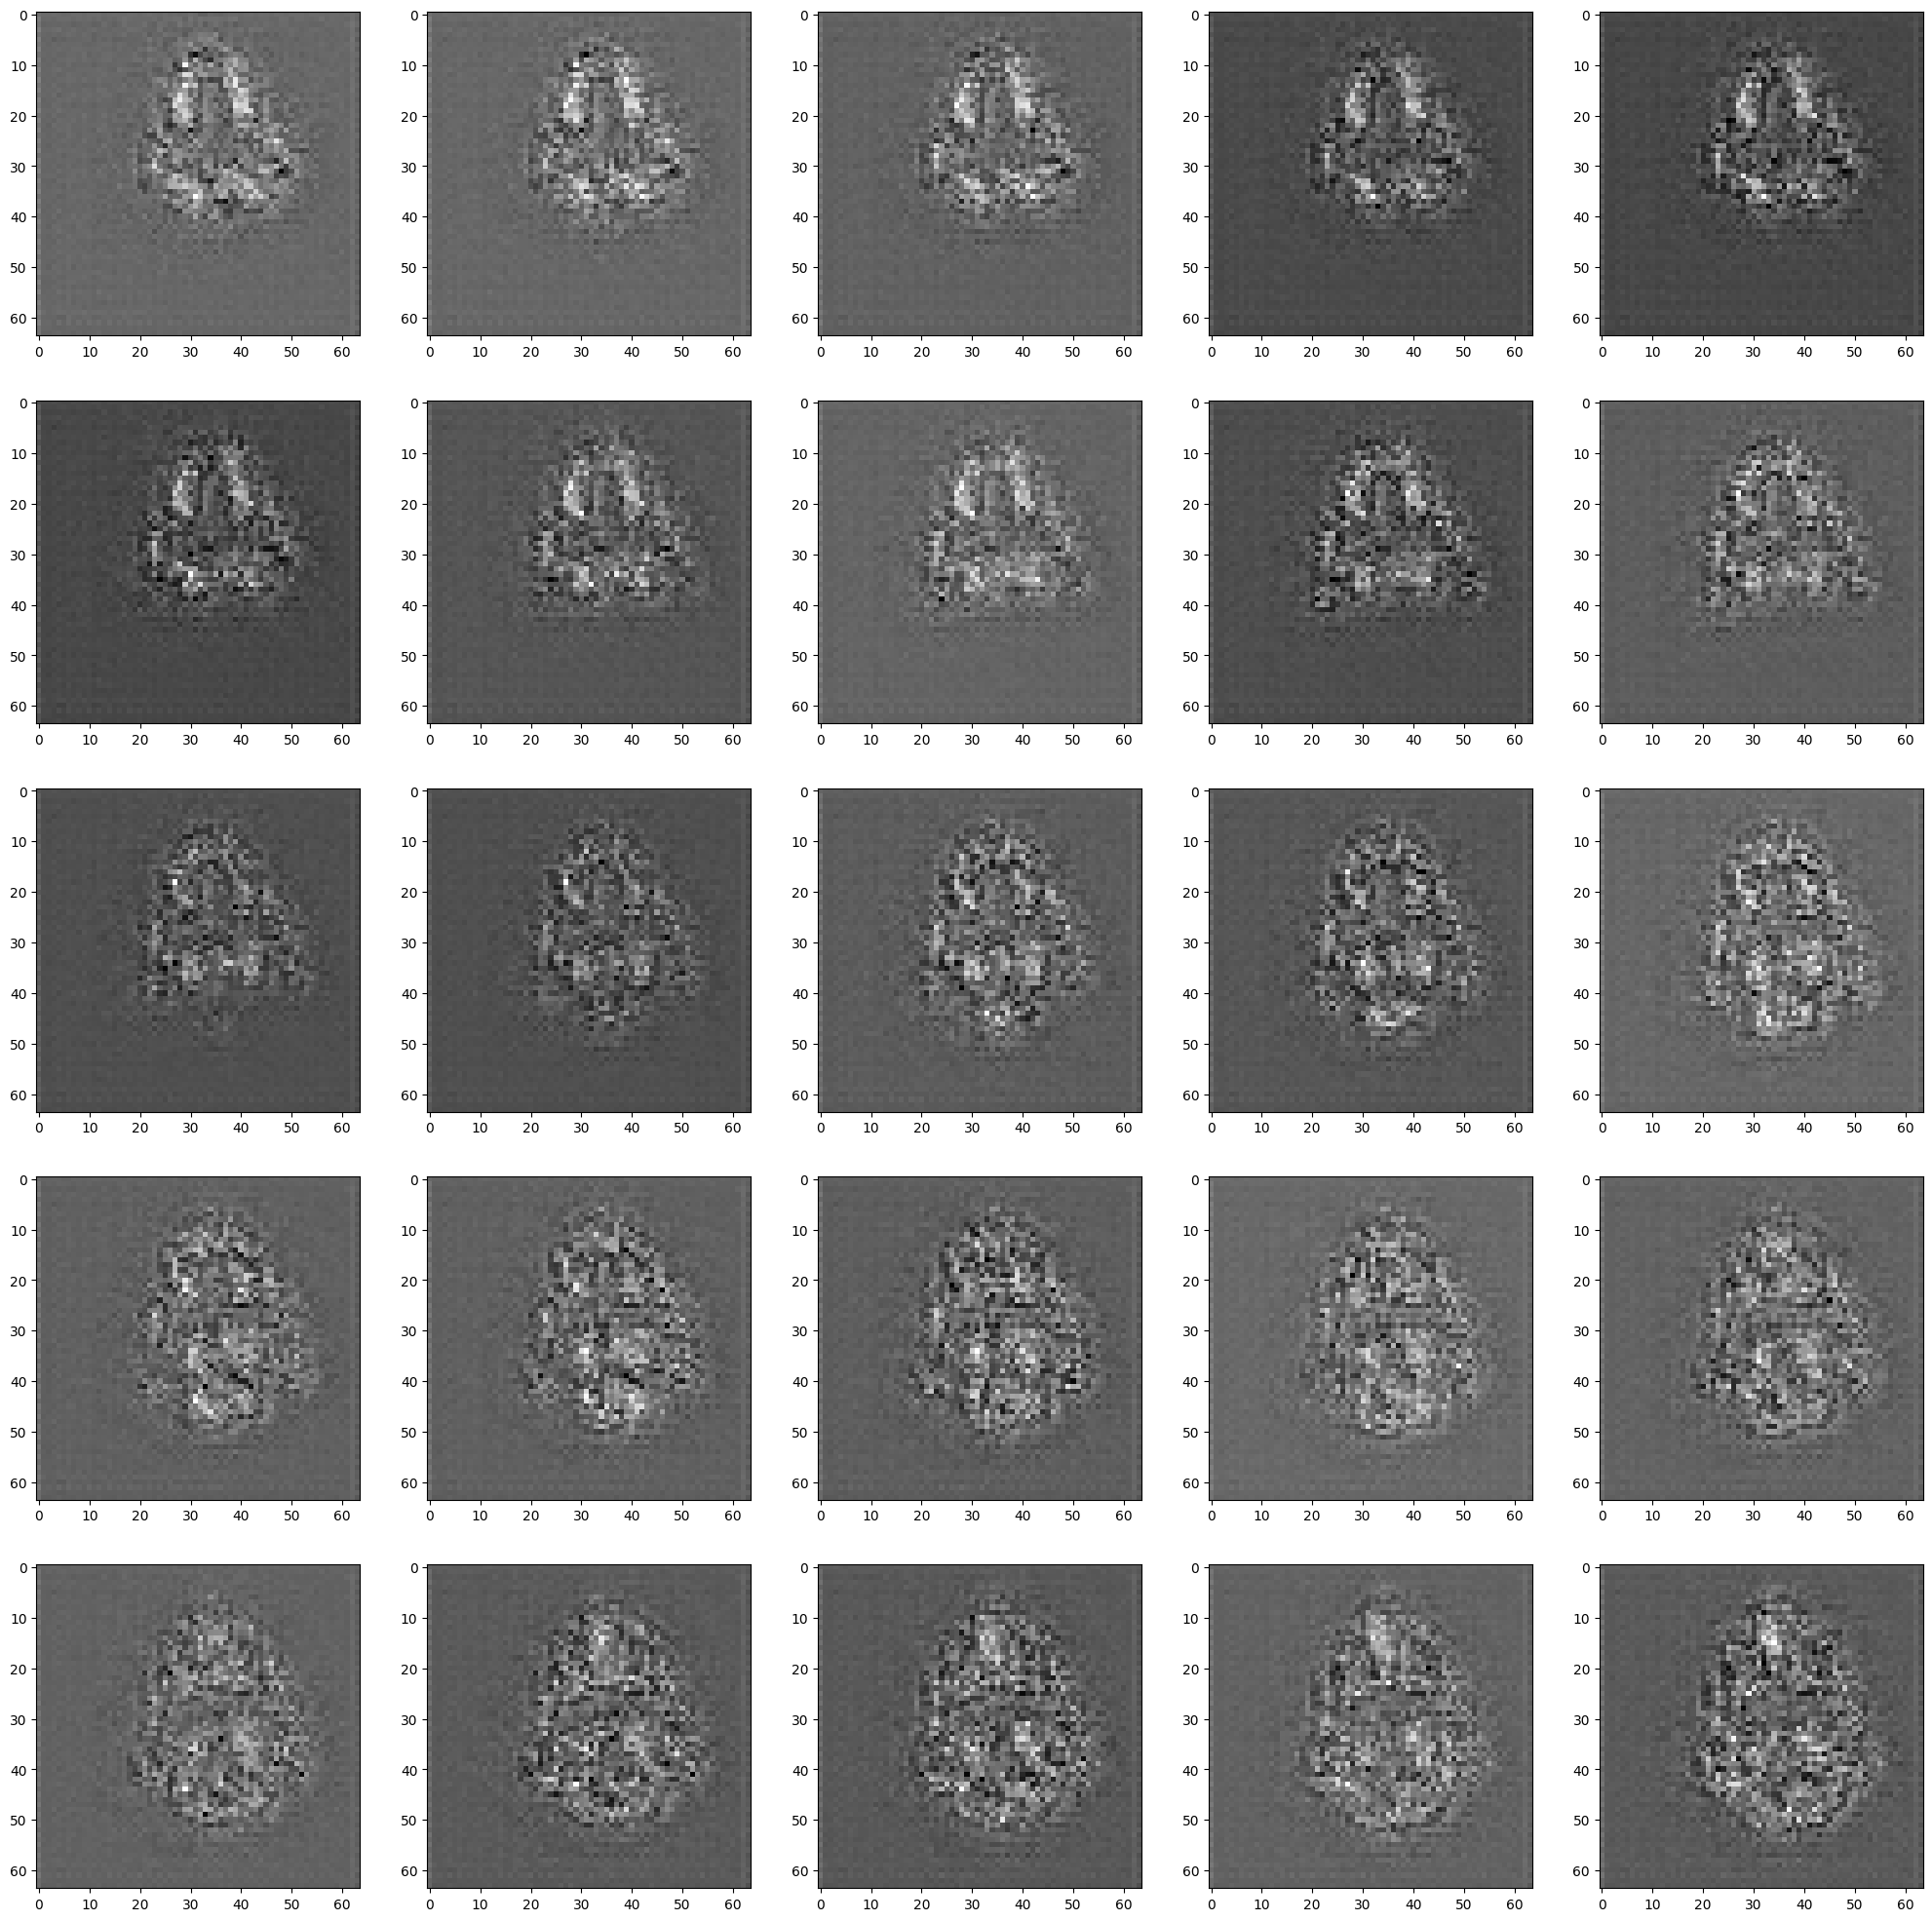

In [146]:
k = 0
plt.figure(figsize=(25,25))
for i in range(25):
  plt.subplot(5,5, i+1)
  plt.imshow(reconstruction[k].numpy().reshape(i_height, i_width), cmap='gray')
  k+=1

plt.show()

In [147]:
torch.save(model.state_dict(), '_model_weights_full.pth')